In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, GRU,LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [3]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

In [4]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [5]:
df['Date']=df.index

In [6]:
start_date='2011-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [7]:
df=df.loc[mask]

In [8]:
df=df.loc[mask]

In [9]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [10]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [11]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [12]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [13]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (2427, 50) Y.shape (2427,)


In [14]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

Bi-LSTM

In [15]:
i=Input(shape=(T,1))
x=Bidirectional(LSTM(200,return_sequences=True))(i)
x=Bidirectional(LSTM(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_lstm=Model(i,x)
model_bi_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 400)          323200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 400)          961600    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 400)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               40100     
                                                             

In [16]:
check_point_bi_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [17]:
model_bi_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [18]:
r=model_bi_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_lstm]
)

Epoch 1/100
53/53 [==============================] - 44s 696ms/step - loss: 5290.4888 - mae: 26.5437 - mse: 5290.4888 - val_loss: 913.6849 - val_mae: 12.2794 - val_mse: 913.6849
Epoch 2/100
53/53 [==============================] - 37s 684ms/step - loss: 5277.5322 - mae: 26.4215 - mse: 5277.5322 - val_loss: 912.6581 - val_mae: 12.2196 - val_mse: 912.6581
Epoch 3/100
53/53 [==============================] - 35s 660ms/step - loss: 5274.7690 - mae: 26.4369 - mse: 5274.7690 - val_loss: 912.8833 - val_mae: 12.2230 - val_mse: 912.8833
Epoch 4/100
53/53 [==============================] - 34s 643ms/step - loss: 5268.0889 - mae: 26.3706 - mse: 5268.0889 - val_loss: 914.9434 - val_mae: 12.3045 - val_mse: 914.9434
Epoch 5/100
53/53 [==============================] - 34s 642ms/step - loss: 5259.0942 - mae: 26.3672 - mse: 5259.0942 - val_loss: 913.7590 - val_mae: 12.1938 - val_mse: 913.7590
Epoch 6/100
53/53 [==============================] - 35s 651ms/step - loss: 5244.7437 - mae: 26.3672 - mse: 52

Bi-directional GRU

In [19]:
i=Input(shape=(T,1))
x=Bidirectional(GRU(200,return_sequences=True))(i)
x=Bidirectional(GRU(200,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_bi_gru=Model(i,x)
model_bi_gru.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 400)          243600    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 400)          722400    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 400)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 100)               40100     
                                                           

In [20]:
check_point_bi_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [21]:
model_bi_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [22]:
r=model_bi_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_bi_gru]
)

Epoch 1/100
53/53 [==============================] - 37s 565ms/step - loss: 5300.4043 - mae: 26.5745 - mse: 5300.4043 - val_loss: 913.0336 - val_mae: 12.2697 - val_mse: 913.0336
Epoch 2/100
53/53 [==============================] - 29s 541ms/step - loss: 5278.8789 - mae: 26.4137 - mse: 5278.8789 - val_loss: 912.4556 - val_mae: 12.2238 - val_mse: 912.4556
Epoch 3/100
53/53 [==============================] - 29s 542ms/step - loss: 5275.9478 - mae: 26.4552 - mse: 5275.9478 - val_loss: 912.7102 - val_mae: 12.2414 - val_mse: 912.7102
Epoch 4/100
53/53 [==============================] - 28s 524ms/step - loss: 5269.9229 - mae: 26.3785 - mse: 5269.9229 - val_loss: 914.5961 - val_mae: 12.3447 - val_mse: 914.5961
Epoch 5/100
53/53 [==============================] - 29s 546ms/step - loss: 5263.9785 - mae: 26.4086 - mse: 5263.9785 - val_loss: 912.3398 - val_mae: 12.2271 - val_mse: 912.3398
Epoch 6/100
53/53 [==============================] - 29s 546ms/step - loss: 5254.7559 - mae: 26.4083 - mse: 52

Predictions

In [23]:
train_idx[:T+1]=False

In [24]:
Ptrain_bi_lstm=model_bi_lstm.predict(Xtrain).flatten()
Ptest_bi_lstm=model_bi_lstm.predict(Xtest).flatten()

In [25]:
Ptrain_bi_gru=model_bi_gru.predict(Xtrain).flatten()
Ptest_bi_gru=model_bi_gru.predict(Xtest).flatten()

In [26]:
df.loc[train_idx,'Diff Bi-LSTM train prediction']=Ptrain_bi_lstm
df.loc[test_idx,'Diff bi-LSTM test prediction']=Ptest_bi_lstm

In [27]:
df.loc[train_idx,'Diff Bi-GRU train prediction']=Ptrain_bi_gru
df.loc[test_idx,'Diff BiGRU test prediction']=Ptest_bi_gru

In [28]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [29]:
last_train=train.iloc[-1]['Prev Close']

In [30]:
df.loc[train_idx,'train_Bi_LSTM']=prev[train_idx]+Ptrain_bi_lstm
df.loc[test_idx,'Prediction_Bi_LSTM']=prev[test_idx]+Ptest_bi_lstm

In [31]:
df.loc[train_idx,'train_Bi_GRU']=prev[train_idx]+Ptrain_bi_gru
df.loc[test_idx,'Prediction_Bi_GRU']=prev[test_idx]+Ptest_bi_gru

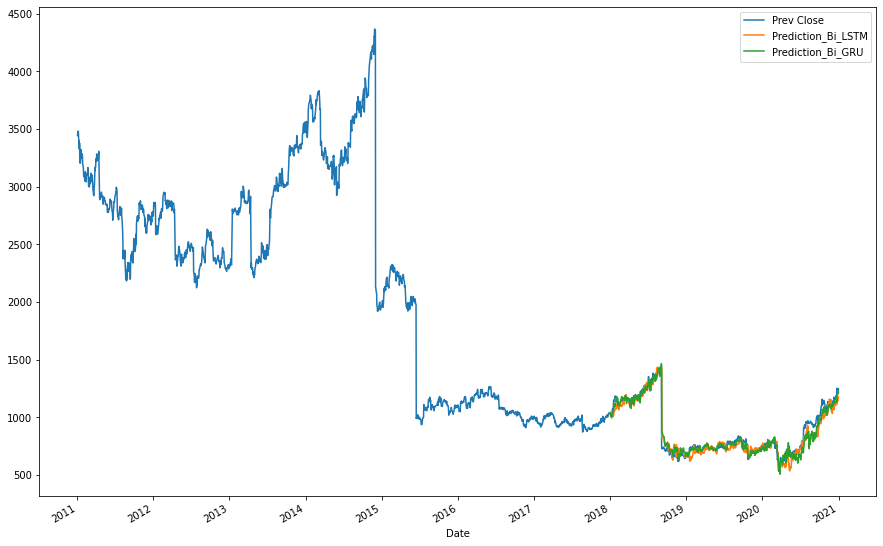

In [32]:
df[[ 'Prev Close','Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

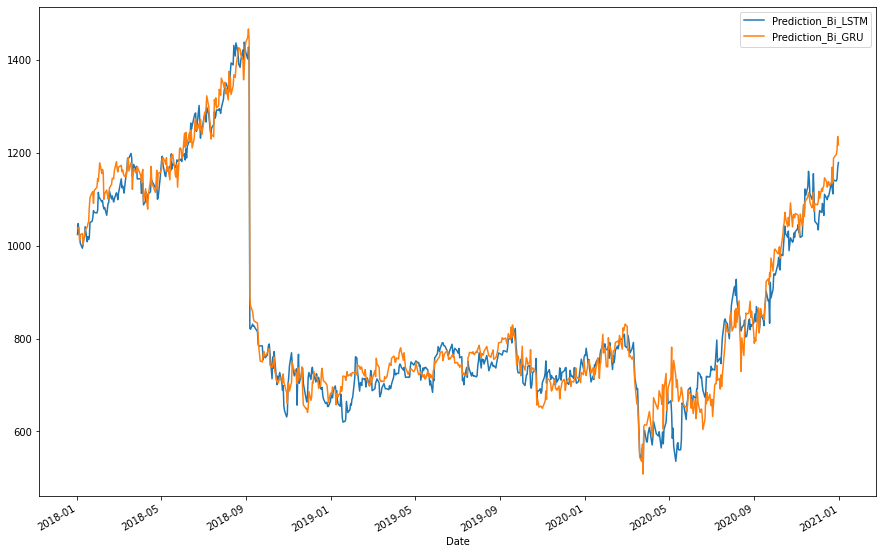

In [33]:
df[[ 'Prediction_Bi_LSTM','Prediction_Bi_GRU']].plot(figsize=(15,10));

Evaluation

In [34]:
pred_bi_lstm=df['Prediction_Bi_LSTM']
pred_bi_lstm.dropna(inplace=True)

In [35]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_lstm))
print(rmse)

60.16643242647977


In [36]:
error=mean_absolute_error(test['Prev Close'],pred_bi_lstm)
print(error)

43.473338640069095


In [37]:
r2_score(test['Prev Close'],pred_bi_lstm)

0.9292907720228395

In [38]:
pred_bi_gru=df['Prediction_Bi_GRU']
pred_bi_gru.dropna(inplace=True)

In [39]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_bi_gru))
print(rmse)

54.53253875019945


In [40]:
error=mean_absolute_error(test['Prev Close'],pred_bi_gru)
print(error)

35.33277361802155


In [41]:
r2_score(test['Prev Close'],pred_bi_gru)

0.9419129919543149